In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.optimize import minimize
from soft_dtw import _distance, _soft_dtw, soft_dtw

Let's create data

In [2]:
t = jnp.linspace(0, 2 * jnp.pi, 32)
timeseries_1 = jnp.sin(t)
timeseries_2 = jnp.cos(t)
series = [timeseries_1, timeseries_2]

In [3]:
def cov_map(cov_fn, xs, ys):

    mv = jax.vmap(cov_fn, (0, None), 0)
    mm = jax.vmap(mv, (None, 0), 1)
    ret = mm(xs, ys)
    return ret

In [4]:
def soft_dtw_metric_custom_vjp(prediction, target, gamma=0.1):
    prediction = prediction[:, None]
    target = target[:, None]
    matrix = cov_map(_distance, prediction, target)
    # this function use custom VJP
    return soft_dtw(matrix, gamma=gamma)


def soft_dtw_metric_use_jax_diff(prediction, target, gamma=0.1):
    prediction = prediction[:, None]
    target = target[:, None]
    matrix = cov_map(_distance, prediction, target)
    # no VJP
    return _soft_dtw(matrix, gamma=gamma, return_last=False)[-1, -1]

The following is the barycenter algorithm

In [5]:
def barycenter(timeseries, metric):
    def loss_fn(curve):
        return sum(metric(curve, ts) for ts in timeseries)

    init = jnp.zeros_like(timeseries[1])
    result = minimize(loss_fn, init, method="bfgs").x

    return result

Start training

In [6]:
result_use_custom_vjp = barycenter(series, metric=soft_dtw_metric_custom_vjp)

In [7]:
result_use_jax_diff = barycenter(series, metric=soft_dtw_metric_use_jax_diff)

Text(0.5, 1.0, 'No custom')

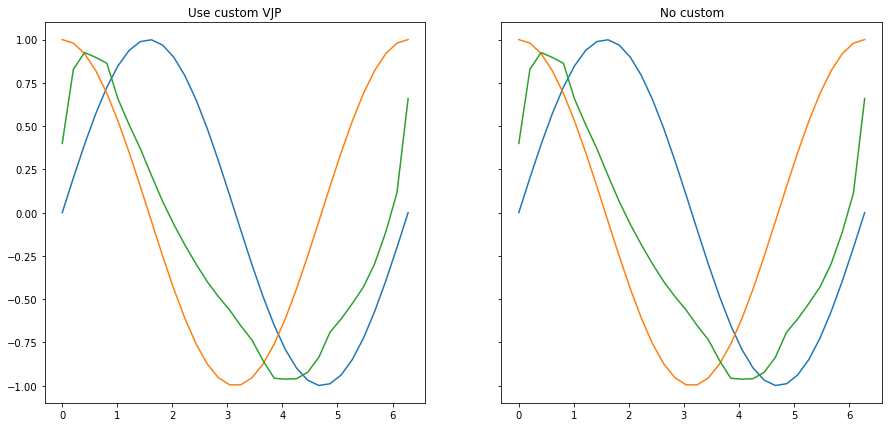

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

for ax in axs:
    ax.plot(t, timeseries_1, label="timeseries_1")
    ax.plot(t, timeseries_2, label="timeseries_2")

axs[0].plot(t, result_use_custom_vjp)
axs[0].set_title("Use custom VJP")
axs[1].plot(t, result_use_jax_diff)
axs[1].set_title("No custom")

### The two plots are identical. So the custom VJP is implemented successfully

In [9]:
# evaluate how long it takes for custom VJP
%timeit barycenter(series, metric=soft_dtw_metric_custom_vjp)

5.38 s ± 91.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
# evaluate how long it takes for no custom JVP
%timeit barycenter(series, metric=soft_dtw_metric_use_jax_diff)

7.15 s ± 78.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### We can see an improvement in performance